In [163]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
from astropy.io import ascii
from hyperion.model import ModelOutput

pc = const.pc.cgs.value
dstar = 178.
wave = 1.6

In [164]:
# rtout for analysis
rt_reg = ModelOutput('/Users/yaolun/bhr71/hyperion/model12.rtout')
rt_const = ModelOutput('/Users/yaolun/bhr71/hyperion/model13.rtout')
rt_r2 = ModelOutput('/Users/yaolun/bhr71/hyperion/model14.rtout')
rt_incl = ModelOutput('/Users/yaolun/bhr71/hyperion/model15.rtout')
rt_r15_hires = ModelOutput('/Users/yaolun/bhr71/hyperion/model18.rtout')
rt_r2_hires = ModelOutput('/Users/yaolun/bhr71/hyperion/model19.rtout')

In [165]:
# get image
def get_image(m):
    image = m.get_image(group=0, inclination=0, distance=dstar * pc, units='MJy/sr')

    # Find the closest wavelength
    iwav = np.argmin(np.abs(wave - image.wav))

    # Calculate the image width in arcseconds given the distance used above
    # get the max radius
    rmax = max(m.get_quantities().r_wall)
    w = np.degrees(rmax / image.distance) * 3600.

    # Image in the unit of MJy/sr
    # Change it into erg/s/cm2/Hz/sr
    factor = 1e-23*1e6
    # avoid zero in log
    # flip the image, because the setup of inclination is upside down
    val = image.val[::-1, :, iwav] * factor + 1e-30
    
    return val, w

im_reg, w = get_image(rt_reg)
im_const, w = get_image(rt_const)
im_r2, w = get_image(rt_r2)
im_incl, w = get_image(rt_incl)

im_r2_hires, w = get_image(rt_r2_hires)
im_r15_hires, w = get_image(rt_r15_hires)

In [156]:
print np.shape(im_r15)

(8000, 8000)


In [145]:
# resolution
print 'Image resolution: ', 2*w/len(im_reg[:,0]), 'arcsec'
31/(2*w/len(im_reg[:,0]))

Image resolution:  0.115668815905 arcsec


268.00654746386215

In [158]:
# rebin function
def rebin(data, width, method='savgol', norm=False, interp=False, log=False):
    """
    If the method is "sigma_clip," the value of width will be treated as sigma.
    """
    # the input width for gaussian kernel is FWHM
    from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
    if method == 'boxcar':
        kernel = Box1DKernel(width, mode='center')
        smooth_data = convolve(data, kernel)
    elif method == 'gaussian':
        kernel = Gaussian1DKernel(width/2.354)
        smooth_data = convolve(data, kernel)
    elif method == 'savgol':
        from scipy.signal import savgol_filter
        if width % 2 == 0:
            width = width+1
        smooth_data = savgol_filter(data, width, 2)
    elif method == 'sigma_clip':
        from astropy.stats import sigma_clip
        smooth_data = sigma_clip(data,sigma=width)
        
        # The interpolation function interpolates the masked value with nearby data
        if interp:
            from scipy.interpolate import interp1d
            x = np.linspace(1, len(data), len(data))
            print len(x[smooth_data.mask]), len(smooth_data.data[smooth_data.mask])
            f = interp1d(x[smooth_data.mask], smooth_data.data[smooth_data.mask])
            interp_data = f(x[np.invert(smooth_data.mask)])
            unsort_data = np.hstack((smooth_data.data[smooth_data.mask], interp_data))
            unsort_x = np.hstack((x[smooth_data.mask], x[np.invert(smooth_data.mask)]))
            sorter = np.argsort(unsort_x)
            smooth_data = unsort_data[sorter]
    if norm:
        smooth_data = smooth_data/smooth_data.max()
    if log:
        smooth_data = np.log10(smooth_data)
    return smooth_data

## radial brightness profiles

/Users/yaolun/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:37: RuntimeWarning: invalid value encountered in log10


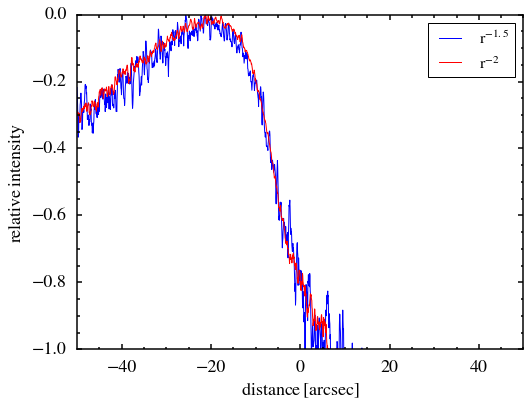

In [161]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

r_im = np.linspace(-w, w, 4000)
r_im_hires = np.linspace(-w, w, 8000)
rebin_pix = 10
# ax.plot(rebin(r_im,rebin_pix), rebin(np.sum(im_reg[:,1949:2049], axis=1), rebin_pix, norm=True),
#         'b-', label=r'$\rm{const.+r^{-2}}$')

ax.plot(rebin(r_im_hires,rebin_pix), rebin(np.sum(im_r15[:,3809:4209], axis=1), rebin_pix, norm=True, log=True),
        'b-', label=r'$\rm{r^{-1.5}}$')
ax.plot(rebin(r_im_hires,rebin_pix), rebin(np.sum(im_r2[:,3809:4209], axis=1), rebin_pix, norm=True, log=True),
        'r-', label=r'$\rm{r^{-2}}$')
# ax.plot(rebin(r_im,rebin_pix), rebin(np.sum(im_const[:,1949:2049], axis=1), rebin_pix, norm=True),
#         'k-', label=r'$\rm{const.}$')
# ax.plot(rebin(r_im,rebin_pix,), rebin(np.sum(im_incl[:,1949:2049], axis=1), rebin_pix, norm=True),
#         'g-', label=r'$\rm{\theta_{incl.}=84^{\circ}}$')

# ax.set_ylim([-1, 0])
# ax.set_xlim([-50,50])
ax.set_ylim([-0.1, 1])
ax.legend(loc='best', fontsize=16)
ax.set_xlabel(r'$\rm{distance\,[arcsec]}$', fontsize=18)
ax.set_ylabel(r'$\rm{relative\,intensity}$', fontsize=18)
[ax.spines[axis].set_linewidth(1.5) for axis in ['top','bottom','left','right']]
ax.minorticks_on()
ax.tick_params('both',labelsize=18,width=1.5,which='major',pad=10,length=5)
ax.tick_params('both',labelsize=18,width=1.5,which='minor',pad=10,length=2.5)

# fig.savefig('/Users/yaolun/test/cavity_brightness.pdf', format='pdf', dpi=300, bbox_inches='tight')

## Brightness profile in equatorial plane

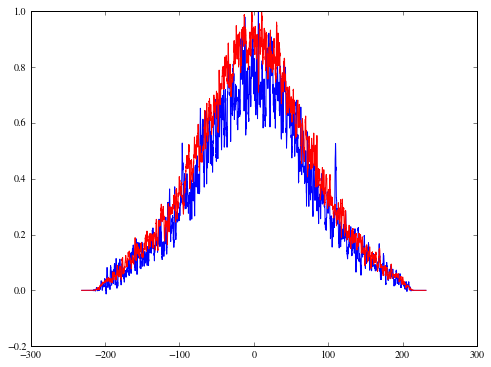

In [136]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

r_im = np.linspace(-w, w, 4000)
rebin_pix = 20
ax.plot(rebin(r_im,rebin_pix), rebin(np.sum(im_reg[2709:3009,:], axis=0), rebin_pix, norm=True),
        'b-', label=r'$\rm{const.+r^{-2}}$')
ax.plot(rebin(r_im,rebin_pix), rebin(np.sum(im_r2[2709:3009,:], axis=0), rebin_pix, norm=True),
        'r-', label=r'$\rm{r^{-2}}$')